## STEP 1: INSTALLATION & IMPORTS

In [2]:
# --- 1. Installation ---
# Cài đặt tất cả các thư viện cần thiết.
# -qU: quiet (im lặng), upgrade (nâng cấp)
print("Bắt đầu cài đặt các thư viện...")
!pip install -qU langgraph langchain langchain-core langchain-community groq python-dotenv rich

Bắt đầu cài đặt các thư viện...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [3]:
!pip install -qU tavily-python google-api-python-client google-auth-oauthlib
print("Đã cài đặt các thư viện công cụ cần thiết.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.9 MB/s eta 0:00:00
Đã cài đặt các thư viện công cụ cần thiết.


In [4]:
!pip install google-auth-httplib2 langchain-groq

In [5]:
# --- 2. Core Imports ---
# Import các thư viện và lớp (class) cốt lõi sẽ được sử dụng trong toàn bộ dự án.
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from google.colab import userdata

# LangChain & LangGraph core components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Groq client for LLM interaction
from groq import AsyncGroq

# Rich library for beautiful printing
from rich.console import Console
from rich.markdown import Markdown

SHOW_DETAILED_LOGS = True

print("\nCài đặt và Import hoàn tất. Môi trường đã sẵn sàng!")


Cài đặt và Import hoàn tất. Môi trường đã sẵn sàng!


## STEP 2: STATE DEFINITION & LLM WRAPPER

In [1]:
# ==============================================================================
# STEP 2: STATE DEFINITION & LANGCHAIN LLM
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator
import json
import os
import tavily
from datetime import datetime, timezone, timedelta

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage
from rich.console import Console
from rich.markdown import Markdown
from google.colab import userdata
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END

# --- 1. State Definition (Hoàn chỉnh) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else: merged[key] = value
    return merged

class AcademicState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    profile: Dict
    cross_agent_request: Optional[Dict[str, Any]]
    required_agents: List[str]
    completed_agents: Annotated[List[str], operator.add]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts]
    critique: str
    revision_needed: bool
    revision_count: int
    final_report: str
    next_steps: str

print("Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.")

# --- 2. Khởi tạo LLM ---
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
    llm = ChatGroq(
        temperature=0.2, # Giảm độ "sáng tạo" để agent tuân thủ hướng dẫn hơn
        model="llama3-70b-8192",
        api_key=GROQ_API_KEY,
        max_tokens=4096
    )
    print(f"Khởi tạo ChatGroq thành công với model: {llm.model_name}")
except Exception as e:
    print(f"LỖI: Không thể khởi tạo LLM. {e}")
    llm = None
console = Console()
if llm: print("\nKhởi tạo 'llm' và 'console' thành công.")


# ==============================================================================
# STEP 3: THE TOOLBOX (PHIÊN BẢN SỬA LỖI CUỐI CÙNG)
# ==============================================================================
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build

# --- 1. Khởi tạo các service và dữ liệu ---
SERVICE_ACCOUNT_FILE = 'credentials.json'
# <-- SỬA ĐỔI QUAN TRỌNG: Thêm ID Lịch của bạn vào đây
YOUR_CALENDAR_ID = "td.tan2711@gmail.com"

def authenticate_google_calendar_service_account():
    try:
        if not os.path.exists(SERVICE_ACCOUNT_FILE): return None
        SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']
        creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        service = build('calendar', 'v3', credentials=creds)
        print("✅ Xác thực Google Calendar thành công.")
        return service
    except Exception as e:
        print(f"Lỗi khi xác thực Google Calendar: {e}")
        return None
google_calendar_service = authenticate_google_calendar_service_account()

try:
    with open('tasks.json', 'r', encoding='utf-8') as f: task_data = json.load(f)
    print("✅ Đã tải dữ liệu tasks.json thành công.")
except Exception as e:
    task_data = {}
    print(f"Lỗi khi tải tasks.json: {e}")

try:
    with open('profile.json', 'r', encoding='utf-8') as f: profile_data = json.load(f)
    print("✅ Đã tải dữ liệu profile.json thành công.")
except Exception as e:
    profile_data = {}
    print(f"Lỗi khi tải profile.json: {e}")

# --- 2. Định nghĩa các công cụ ---
@tool
def google_calendar_reader(days_ahead: int = 7) -> str:
    """Sử dụng công cụ này để đọc lịch và các sự kiện sắp tới của người dùng."""
    if not google_calendar_service: return "Lỗi: Dịch vụ Google Calendar không có sẵn."
    now_utc = datetime.now(timezone.utc).isoformat()
    future_limit = (datetime.now(timezone.utc) + timedelta(days=days_ahead)).isoformat()
    try:
        print(f"--- [Calendar Tool] Đang đọc lịch: {YOUR_CALENDAR_ID}")
        # <-- SỬA ĐỔI QUAN TRỌNG: Sử dụng ID lịch của bạn thay vì 'primary'
        events_result = google_calendar_service.events().list(
            calendarId=YOUR_CALENDAR_ID,
            timeMin=now_utc,
            timeMax=future_limit,
            singleEvents=True,
            orderBy='startTime'
        ).execute()
        events = events_result.get('items', [])
        if not events:
            return f"Không có sự kiện nào sắp tới trong {days_ahead} ngày tới."
        print(f"--- [Calendar Tool] Tìm thấy {len(events)} sự kiện.")
        # Trả về một chuỗi JSON sạch
        return json.dumps([{'summary': e.get('summary'), 'start': e.get('start', {}).get('dateTime'), 'end': e.get('end', {}).get('dateTime')} for e in events])
    except Exception as e: return f"Lỗi khi gọi Google Calendar API: {e}"

@tool
def active_tasks_reader() -> str:
    """Sử dụng công cụ này để đọc danh sách các công việc và bài tập còn hoạt động của người dùng."""
    if not task_data: return "Không có dữ liệu công việc."
    now_utc = datetime.now(timezone.utc)
    active_tasks = [t for t in task_data.get("tasks", []) if t.get("status") == "needsAction" and t.get("due") and datetime.fromisoformat(t['due'].replace('Z', '+00:00')) > now_utc]
    return "Không có công việc nào còn hoạt động." if not active_tasks else json.dumps(active_tasks)

@tool
def tavily_web_search(query: str) -> str:
    """Sử dụng công cụ này để tìm kiếm thông tin học thuật trên Internet khi người dùng yêu cầu tìm hiểu về một chủ đề cụ thể."""
    try:
        client = tavily.TavilyClient(api_key=TAVILY_API_KEY)
        response = client.search(query=query, search_depth="advanced", max_results=5)
        return "\n\n".join([f'Source: {res["url"]}\nContent: {res["content"]}' for res in response["results"]])
    except Exception as e: return f"Lỗi khi tìm kiếm với Tavily: {e}"

# --- 3. Tạo danh sách và bind các công cụ ---
tools = [google_calendar_reader, active_tasks_reader, tavily_web_search]
llm_with_tools = llm.bind_tools(tools)
print("\n✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.")

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


Đã định nghĩa 'AcademicState' phiên bản cuối cùng thành công.
Khởi tạo ChatGroq thành công với model: llama3-70b-8192

Khởi tạo 'llm' và 'console' thành công.
✅ Xác thực Google Calendar thành công.
✅ Đã tải dữ liệu tasks.json thành công.
✅ Đã tải dữ liệu profile.json thành công.

✅ Hộp dụng cụ (Toolbox) đã sẵn sàng và được bind vào LLM.


In [2]:
# ==============================================================================
# STEP 4: THE FULL INTERACTIVE TEAM OF AGENTS (PHIÊN BẢN CUỐI CÙNG)
# ==============================================================================
import re
import time
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal, Dict, Any

# --- 1. Định nghĩa các cấu trúc dữ liệu cho tương tác ---
class FinalAnswer(BaseModel):
    """Sử dụng để cung cấp câu trả lời cuối cùng."""
    answer: str = Field(description="Nội dung câu trả lời cuối cùng, chi tiết bằng Markdown.")

# --- 2. Xây dựng các Agent ---

async def coordinator_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---")
    prompt = f"Dựa trên yêu cầu: '{state['messages'][0].content}', quyết định các agent cần kích hoạt. Các lựa chọn: PLANNER, NOTEWRITER, ADVISOR. Trả về một danh sách Python."
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    try:
        required_agents = eval(response_message.content.strip())
        if not isinstance(required_agents, list): raise ValueError
    except:
        required_agents = ["PLANNER", "NOTEWRITER", "ADVISOR"]
    print(f"--- [Coordinator] Quyết định: Cần các agent {required_agents}")
    return {"required_agents": required_agents}

async def tool_user_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Tool User] Thu thập tất cả thông tin ban đầu... ---")
    request = state['messages'][0].content
    search_query = f"Hướng dẫn học và các tài liệu tốt nhất về '{request}'"
    print(f"--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'active_tasks_reader', 'tavily_web_search']")
    calendar_output = google_calendar_reader.invoke({"days_ahead": 7})
    time.sleep(1)
    tasks_output = active_tasks_reader.invoke({})
    time.sleep(1)
    web_output = tavily_web_search.invoke({"query": search_query})
    collected_data = f"""Thông tin ban đầu đã được thu thập:
    1. Lịch trình trong 7 ngày tới: {calendar_output}
    2. Các nhiệm vụ đang hoạt động: {tasks_output}
    3. Kết quả tìm kiếm trên web: {web_output}"""
    context_message = SystemMessage(content=collected_data)
    print("--- [Tool User] Đã thu thập và định dạng xong thông tin.")
    return {"messages": [context_message]}

def create_specialist_agent(agent_name: str, agent_description: str, output_key: str):
    async def specialist_agent(state: AcademicState) -> Dict[str, Any]:
        print(f"\n--- [{agent_name}] Bắt đầu làm việc... ---")
        llm_with_tool = llm.bind_tools([FinalAnswer])
        prompt = f"""Bạn là {agent_name}. {agent_description}.
        Dựa vào TOÀN BỘ thông tin có sẵn dưới đây, hãy tạo ra sản phẩm tốt nhất có thể của bạn và gọi công cụ `FinalAnswer`.
        **Thông tin có sẵn (Yêu cầu gốc, Lịch, Nhiệm vụ, Kết quả tìm kiếm, Sản phẩm của agent khác):**
        ```json
        {json.dumps({
            "profile": state['profile'],
            "messages": [msg.model_dump() for msg in state['messages']],
            "agent_outputs": state['agent_outputs'],
        }, indent=2, ensure_ascii=False)}
        ```
        Hãy tạo ra câu trả lời cuối cùng của bạn ngay bây giờ.
        """
        try:
            ai_response = await llm_with_tool.ainvoke([HumanMessage(content=prompt)])
            if not ai_response.tool_calls:
                print(f"--- [{agent_name}] Cảnh báo: Không gọi được tool, trả về nội dung thô.")
                return {"agent_outputs": {output_key: ai_response.content}}
            tool_call = ai_response.tool_calls[0]
            if tool_call['name'] == 'FinalAnswer':
                print(f"--- [{agent_name}] Đã tạo sản phẩm thành công.")
                return {"agent_outputs": {output_key: tool_call['args']['answer']}}
            else:
                raise ValueError(f"LLM đã gọi một công cụ không xác định: {tool_call['name']}")
        except Exception as e:
            # --- LOGIC CỨU KẾT QUẢ TỪ LỖI 400 ---
            print(f"--- [{agent_name}] Gặp lỗi API: {e}")
            error_str = str(e)
            match = re.search(r'"answer":\s*"(.*?)"', error_str, re.DOTALL)
            if match:
                extracted_answer = match.group(1).encode().decode('unicode_escape')
                print(f"--- [{agent_name}] Đã cứu được sản phẩm từ lỗi 400!")
                return {"agent_outputs": {output_key: extracted_answer}}
            else:
                print(f"--- [{agent_name}] Không thể cứu sản phẩm. Trả về thông báo lỗi.")
                return {"agent_outputs": {output_key: f"Agent {agent_name} đã gặp lỗi không thể phục hồi."}}
    return specialist_agent

planner_agent = create_specialist_agent("PLANNER", "Tạo kế hoạch học tập chi tiết, khả thi.", "plan")
notewriter_agent = create_specialist_agent("NOTEWRITER", "Tạo ghi chú học thuật súc tích.", "notes")
advisor_agent = create_specialist_agent("ADVISOR", "Đưa ra lời khuyên chiến lược.", "advice")

async def synthesizer_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---")
    prompt = f"Tổng hợp các sản phẩm từ các chuyên gia sau đây thành MỘT báo cáo tổng hợp duy nhất, mạch lạc và chuyên nghiệp cho người dùng:\n\n{json.dumps(state['agent_outputs'], indent=2, ensure_ascii=False)}.\n\nYêu cầu ban đầu của người dùng là: '{state['messages'][0].content}'"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"final_report": response_message.content}

async def reflection_agent(state: AcademicState) -> Dict[str, Any]:
    print("\n--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---")
    prompt = f"Dựa vào báo cáo cuối cùng này, hãy đề xuất 3-4 hành động hoặc câu hỏi tiếp theo mà người dùng có thể muốn thực hiện:\n\n{state['final_report']}"
    response_message = await llm.ainvoke([HumanMessage(content=prompt)])
    return {"next_steps": response_message.content}

print("✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản hoàn thiện) đã được định nghĩa.")

✅ Tất cả các agent cho ATLAS 2.0 (Phiên bản hoàn thiện) đã được định nghĩa.


In [3]:
# ==============================================================================
# STEP 5 & 6: ASSEMBLY & EXECUTION (KIẾN TRÚC CUỐI CÙNG)
# ==============================================================================

# Node wrapper để chạy agent và đánh dấu hoàn thành
async def specialist_node_wrapper(agent_func, agent_name: str, state: AcademicState) -> Dict[str, Any]:
    # Chạy agent
    result = await agent_func(state)

    # Đánh dấu đã hoàn thành
    current_completed = state.get("completed_agents", [])
    if agent_name not in current_completed:
        # Sử dụng toán tử `add` của `Annotated` bằng cách trả về một danh sách
        result["completed_agents"] = [agent_name]

    return result

# <-- SỬA ĐỔI QUAN TRỌNG: Định nghĩa các node một cách tường minh
async def planner_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(planner_agent, "PLANNER", state)

async def notewriter_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(notewriter_agent, "NOTEWRITER", state)

async def advisor_node(state: AcademicState) -> Dict[str, Any]:
    return await specialist_node_wrapper(advisor_agent, "ADVISOR", state)

# --- Lắp ráp Graph ---
workflow = StateGraph(AcademicState)
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("tool_user", tool_user_agent)
# Sử dụng các hàm async def đã được định nghĩa đúng cách
workflow.add_node("planner", planner_node)
workflow.add_node("notewriter", notewriter_node)
workflow.add_node("advisor", advisor_node)
workflow.add_node("synthesizer", synthesizer_agent)
workflow.add_node("reflection", reflection_agent)

workflow.set_entry_point("coordinator")

# Luồng chạy tuần tự, thẳng và đơn giản
# Coordinator quyết định các agent cần chạy
workflow.add_edge("coordinator", "tool_user")
# Tool user thu thập tất cả thông tin ban đầu
workflow.add_edge("tool_user", "planner")

# Sau planner, đi đến notewriter
workflow.add_edge("planner", "notewriter")
# Sau notewriter, đi đến advisor
workflow.add_edge("notewriter", "advisor")
# Sau advisor, đi tổng hợp
workflow.add_edge("advisor", "synthesizer")

# Luồng cuối cùng
workflow.add_edge("synthesizer", "reflection")
workflow.add_edge("reflection", END)

app = workflow.compile()
print("\n✅✅✅ ATLAS 2.0 (Kiến trúc cuối cùng) đã được biên dịch! ✅✅✅")


✅✅✅ ATLAS 2.0 (Kiến trúc cuối cùng) đã được biên dịch! ✅✅✅


In [4]:
# ==============================================================================
# STEP 7: EXECUTION (Chạy và hiển thị kết quả đúng)
# ==============================================================================

async def run_atlas_2_0(profile_data: dict):
    request = "Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập."

    student_profile = next((p for p in profile_data.get("profiles", []) if p.get("id") == "student_123"), {})

    initial_state = {
        "messages": [HumanMessage(content=request)],
        "profile": student_profile,
        "agent_outputs": {},
        "completed_agents": [],
    }

    console.print(f"\n🚀 [bold blue]Bắt đầu chạy ATLAS 2.0 với yêu cầu:[/bold blue]\n{request}")

    # Chạy và xem log của từng bước
    async for step in app.astream(initial_state, config={"recursion_limit": 15}):
        node_name = list(step.keys())[0]
        console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
        console.print(step[node_name])

    # Sau khi chạy xong, gọi `ainvoke` để lấy trạng thái cuối cùng hoàn chỉnh
    print("\n--- [Hệ thống] Đang lấy kết quả cuối cùng... ---")
    final_state = await app.ainvoke(initial_state, config={"recursion_limit": 15})

    console.print("\n\n" + "="*80, style="bold green")
    console.print(" HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!", style="bold green")
    console.print("="*80, style="bold green")

    # In kết quả từ trạng thái cuối cùng
    if final_state:
        console.print("\n--- [bold blue]BÁO CÁO TỔNG HỢP CUỐI CÙNG[/bold blue] ---")
        console.print(Markdown(final_state.get("final_report", "Không có báo cáo cuối cùng.")))
        console.print("\n--- [bold blue]GỢI Ý CÁC BƯỚC TIẾP THEO[/bold blue] ---")
        console.print(Markdown(final_state.get("next_steps", "Không có gợi ý.")))

# Chạy hàm chính
await run_atlas_2_0(profile_data)

🚀 Bắt đầu chạy ATLAS 2.0 với yêu cầu:
Tuần tới tôi cần học về thuật toán K-Nearest Neighbors (KNN). Lịch của tôi khá bận rộn, hãy tạo một kế hoạch học 
tập chi tiết, sau đó ghi chú lại các điểm chính và cho tôi một vài lời khuyên học tập.


--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']


✅ Hoàn thành bước: coordinator

{'required_agents': ['PLANNER', 'NOTEWRITER', 'ADVISOR']}


--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'active_tasks_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.


✅ Hoàn thành bước: tool_user

{
    'messages': [
        SystemMessage(
            content='Thông tin ban đầu đã được thu thập:\n    1. Lịch trình trong 7 ngày tới: [{"summary": "Work 
Online", "start": "2025-08-08T19:45:00+07:00", "end": "2025-08-08T21:15:00+07:00"}, {"summary": "Take a nap", 
"start": "2025-08-11T08:45:00+07:00", "end": "2025-08-11T13:00:00+07:00"}, {"summary": "have a trip", "start": 
"2025-08-12T01:30:00+07:00", "end": "2025-08-12T05:30:00+07:00"}, {"summary": "go swimming", "start": 
"2025-08-14T07:15:00+07:00", "end": "2025-08-14T11:45:00+07:00"}]\n    2. Các nhiệm vụ đang hoạt động: [{"id": 
"task_01", "title": "Submit AI project report", "due": "2025-08-10T23:59:00Z", "status": "needsAction", "priority":
"high"}, {"id": "task_02", "title": "Read Chapter 5 - Operating Systems", "due": "2025-08-08T23:59:00Z", "status": 
"needsAction", "priority": "medium"}]\n    3. Kết quả tìm kiếm trên web: Source: 
https://viblo.asia/p/knn-k-nearest-neighbors-1-djeZ14ejKWz\nContent: 1.   Thuật toán đơn giản, dễ dàng triển 
khai.\n2.   Độ phức tạp tính toán nhỏ.\n3.   Xử lý tốt với tập dữ liệu nhiễu\n\nNhược điểm\n==========\n\n1.   Với 
K nhỏ dễ gặp nhiễu dẫn tới kết quả đưa ra không chính xác\n2.   Cần nhiều thời gian để thực hiện do phải tính toán 
khoảng cách với tất cả các đối tượng trong tập dữ liệu.\n3.   Cần chuyển đổi kiểu dữ liệu thành các yếu tố định 
tính.\n\nTrong bài tiếp theo chúng ta sẽ xây dựng một mã nguồn mô phỏng thuật toán KNN trong thực tế. [...] KNN 
(K-Nearest Neighbors) là một trong những thuật toán học có giám sát đơn giản nhất được sử dụng nhiều trong khai phá
dữ liệu và học máy. Ý tưởng của thuật toán này là nó không học một điều gì từ tập dữ liệu học (nên KNN được xếp vào
loại lazy learning), mọi tính toán được thực hiện khi nó cần dự đoán nhãn của dữ liệu mới. \n\nLớp (nhãn) của một 
đối tượng dữ liệu mới có thể dự đoán từ các lớp (nhãn) của k hàng xóm gần nó nhất.\n\nVí dụ:\n------ [...] 1.   Ta 
có D là tập các điểm dữ liệu đã được gắn nhãn và A là dữ liệu chưa được phân loại.\n2.   Đo khoảng cách (Euclidian,
Manhattan, Minkowski, Minkowski hoặc Trọng số) từ dữ liệu mới A đến tất cả các dữ liệu khác đã được phân loại trong
D.\n3.   Chọn K (K là tham số mà bạn định nghĩa) khoảng cách nhỏ nhất.\n4.   Kiểm tra danh sách các lớp có khoảng 
cách ngắn nhất và đếm số lượng của mỗi lớp xuất hiện.\n5.   Lấy đúng lớp (lớp xuất hiện nhiều lần nhất).\n\nSource:
https://machinelearningcoban.com/2017/01/08/knn/\nContent: K-nearest neighbor là một trong những thuật toán 
supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning. Khi training, 
thuật toán này không học một điều gì từ dữ liệu training (đây cũng là lý do thuật toán này được xếp vào loại lazy 
learning), mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới. K-nearest neighbor có thể áp 
dụng được vào cả hai loại của bài toán Supervised learning là Classification và Regression. KNN còn được gọi là 
[...] Một cách ngắn gọn, KNN là thuật toán đi tìm đầu ra của một điểm dữ liệu mới bằng cách chỉ dựa trên thông tin 
của K điểm dữ liệu trong training set gần nó nhất (K-lân cận), không quan tâm đến việc có một vài điểm dữ liệu 
trong những điểm gần nhất này là nhiễu. Hình dưới đây là một ví dụ về KNN trong classification với K = 1. [...] đáp
án đâu - nhiều tài liệu quá cũng mệt!!\n\nSource: 
https://aicandy.vn/kham-pha-k-nearest-neighbors-cho-phan-loai-va-hoi-quy/\nContent: 1. Giới thiệu về K-nearest 
neighbors\n   2. Nguyên lý hoạt động của KNN\n       2.1. Các bước thực hiện\n       2.2. Bài toán phân loại\n     
2.4. Bài toán hồi quy\n\n   3. Chọn giá trị của k\n       3.1. Tầm quan trọng của việc chọn giá trị k\n       3.2. 
Ảnh hưởng của giá trị k đến hiệu suất mô hình\n       3.3. Các phương pháp chọn giá trị k\n       3.4. Các yếu tố 
ảnh hưởng đến việc chọn giá trị k\n       3.5. Tối ưu hóa giá trị k cho từng bài toán cụ thể [...] #### Phát hiện 
thư rác (Spam Detection):\n\n   KNN cũng được sử dụng rộng rãi tr


--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Đã tạo sản phẩm thành công.


✅ Hoàn thành bước: planner

{
    'agent_outputs': {
        'plan': "Based on the provided information, I will create a detailed learning plan for the student to learn
about K-Nearest Neighbors (KNN) algorithm. Considering the student's learning preferences and schedule, I recommend
the following plan:\n\n**Day 1-2:** Review the basics of KNN algorithm, including its advantages and disadvantages,
and how it works.\n\n**Day 3-4:** Study the applications of KNN in real-world scenarios, such as spam detection and
image classification.\n\n**Day 5-6:** Practice implementing KNN algorithm using Python or other programming 
languages.\n\n**Day 7:** Review and summarize the key concepts learned throughout the week.\n\nAdditionally, I 
suggest the student to take breaks and prioritize their tasks according to their schedule. It's also important to 
review and practice regularly to reinforce their understanding of the concept."
    },
    'completed_agents': ['PLANNER']
}


--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Đã tạo sản phẩm thành công.


✅ Hoàn thành bước: notewriter

{
    'agent_outputs': {
        'notes': "Based on the provided information, I will create a detailed learning plan for the student to 
learn about K-Nearest Neighbors (KNN) algorithm. Considering the student's learning preferences and schedule, I 
recommend the following plan:\n\n**Day 1-2:** Review the basics of KNN algorithm, including its advantages and 
disadvantages, and how it works.\n\n**Day 3-4:** Study the applications of KNN in real-world scenarios, such as 
spam detection and image classification.\n\n**Day 5-6:** Practice implementing KNN algorithm using Python or other 
programming languages.\n\n**Day 7:** Review and summarize the key concepts learned throughout the 
week.\n\nAdditionally, I suggest the student to take breaks and prioritize their tasks according to their schedule.
It's also important to review and practice regularly to reinforce their understanding of the concept."
    },
    'completed_agents': ['NOTEWRITER']
}


--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.


✅ Hoàn thành bước: advisor

{
    'agent_outputs': {
        'advice': "Based on the provided information, I recommend a detailed learning plan for the student to learn
about K-Nearest Neighbors (KNN) algorithm. Considering the student's learning preferences and schedule, I suggest 
the following plan:\n\n**Day 1-2:** Review the basics of KNN algorithm, including its advantages and disadvantages,
and how it works.\n\n**Day 3-4:** Study the applications of KNN in real-world scenarios, such as spam detection and
image classification.\n\n**Day 5-6:** Practice implementing KNN algorithm using Python or other programming 
languages.\n\n**Day 7:** Review and summarize the key concepts learned throughout the week.\n\nAdditionally, I 
suggest the student to take breaks and prioritize their tasks according to their schedule. It's also important to 
review and practice regularly to reinforce their understanding of the concept."
    },
    'completed_agents': ['ADVISOR']
}


--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---


✅ Hoàn thành bước: synthesizer

{
    'final_report': 'Here is a comprehensive report that combines the three products from the 
experts:\n\n**Comprehensive Learning Plan for K-Nearest Neighbors (KNN) Algorithm**\n\n**Introduction**\n\nBased on
your request, I have created a detailed learning plan for you to learn about the K-Nearest Neighbors (KNN) 
algorithm, considering your busy schedule and learning preferences.\n\n**Learning Plan**\n\nTo ensure effective 
learning, I recommend the following plan:\n\n**Day 1-2:** Review the basics of KNN algorithm, including its 
advantages and disadvantages, and how it works.\n\n**Day 3-4:** Study the applications of KNN in real-world 
scenarios, such as spam detection and image classification.\n\n**Day 5-6:** Practice implementing KNN algorithm 
using Python or other programming languages.\n\n**Day 7:** Review and summarize the key concepts learned throughout
the week.\n\n**Additional Tips**\n\n* Take breaks and prioritize your tasks according to your schedule.\n* Review 
and practice regularly to reinforce your understanding of the concept.\n\n**Key Notes**\n\n* Review the basics of 
KNN algorithm, including its advantages and disadvantages, and how it works.\n* Study the applications of KNN in 
real-world scenarios, such as spam detection and image classification.\n* Practice implementing KNN algorithm using
Python or other programming languages.\n* Review and summarize the key concepts learned throughout the 
week.\n\n**Advice**\n\nTo ensure successful learning, I suggest that you:\n\n* Follow the recommended learning plan
to stay on track.\n* Take breaks and prioritize your tasks according to your schedule.\n* Review and practice 
regularly to reinforce your understanding of the concept.\n\nBy following this comprehensive learning plan, you 
will be able to gain a thorough understanding of the K-Nearest Neighbors (KNN) algorithm and its applications. Good
luck with your learning!'
}


--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---


✅ Hoàn thành bước: reflection

{
    'next_steps': 'Based on this comprehensive report, here are 3-4 potential next actions or questions that the 
user may want to take:\n\n1. **Start implementing the learning plan**: The user may want to begin following the 
recommended learning plan, starting with reviewing the basics of the KNN algorithm on Day 1-2.\n2. **Explore 
additional resources for practice**: The user may want to ask for additional resources or recommendations for 
practicing the implementation of the KNN algorithm using Python or other programming languages.\n3. **Seek 
clarification on specific concepts**: The user may have questions or need further clarification on certain 
concepts, such as the advantages and disadvantages of the KNN algorithm or its applications in real-world 
scenarios.\n4. **Request a progress tracking mechanism**: The user may want to ask for a way to track their 
progress or receive feedback on their learning, such as a quiz or a checklist to ensure they are staying on track 
with the learning plan.'
}


--- [Hệ thống] Đang lấy kết quả cuối cùng... ---

--- [Coordinator] Đang quyết định các chuyên gia cần thiết... ---
--- [Coordinator] Quyết định: Cần các agent ['PLANNER', 'NOTEWRITER', 'ADVISOR']

--- [Tool User] Thu thập tất cả thông tin ban đầu... ---
--- [Tool User] Quyết định gọi công cụ: ['google_calendar_reader', 'active_tasks_reader', 'tavily_web_search']
--- [Calendar Tool] Đang đọc lịch: td.tan2711@gmail.com
--- [Calendar Tool] Tìm thấy 4 sự kiện.
--- [Tool User] Đã thu thập và định dạng xong thông tin.

--- [PLANNER] Bắt đầu làm việc... ---
--- [PLANNER] Đã tạo sản phẩm thành công.

--- [NOTEWRITER] Bắt đầu làm việc... ---
--- [NOTEWRITER] Đã tạo sản phẩm thành công.

--- [ADVISOR] Bắt đầu làm việc... ---
--- [ADVISOR] Đã tạo sản phẩm thành công.

--- [Synthesizer] Bắt đầu tổng hợp báo cáo cuối cùng ---

--- [Reflection] Đang suy nghĩ về các bước tiếp theo... ---


================================================================================

 HỆ THỐNG ATLAS 2.0 ĐÃ HOÀN THÀNH TÁC VỤ!

================================================================================

--- BÁO CÁO TỔNG HỢP CUỐI CÙNG ---

Here is the consolidated report:                                                                                   

Detailed Study Plan for Learning K-Nearest Neighbors (KNN) Algorithm                                               

Based on your request, I have created a tailored study plan to help you learn the K-Nearest Neighbors (KNN)        
algorithm effectively, considering your busy schedule and learning preferences.                                    

Study Plan:                                                                                                        

 1 Day 1-2: Review the basics of KNN algorithm, its advantages, and disadvantages.                                 
 2 Day 3-4: Watch video lectures and read articles on KNN to understand its implementation and applications.       
 3 Day 5-6: Practice coding exercises and implement KNN algorithm using a programming language of choice.          
 4 Day 7: Review and revise the learned concepts, and take a practice quiz to assess understanding.                

Tips and Recommendations:                                                                                          

 • Create a schedule and stick to it to ensure consistent learning.                                                
 • Use visual aids like diagrams and mind maps to understand complex concepts.                                     
 • Take regular breaks to avoid burnout and maintain focus.                                                        
 • Practice coding exercises to reinforce learning.                                                                
 • Review and revise learned concepts regularly to retain information.                                             

By following this study plan, you can effectively learn the KNN algorithm and its applications. Remember to stay   
committed to your schedule, take breaks, and practice regularly to achieve your learning goals.                    

Key Takeaways:                                                                                                     

 • Review the basics of KNN algorithm, its advantages, and disadvantages.                                          
 • Watch video lectures and read articles on KNN to understand its implementation and applications.                
 • Practice coding exercises and implement KNN algorithm using a programming language of choice.                   
 • Review and revise learned concepts regularly to retain information.                                             

Additional Advice:                                                                                                 

To ensure consistent learning and retention of information, it is essential to stick to your schedule, take regular
breaks, and practice regularly. By following this study plan, you will be able to learn the KNN algorithm          
effectively and apply it in real-world scenarios.

--- GỢI Ý CÁC BƯỚC TIẾP THEO ---

Based on this consolidated report, here are 3-4 potential next actions or questions that the user may want to take:

 1 Start implementing the study plan: The user may want to begin following the study plan, starting with reviewing 
   the basics of the KNN algorithm, its advantages, and disadvantages on Day 1-2.                                  
 2 Choose a programming language for implementation: The user may want to decide on a programming language to use  
   for implementing the KNN algorithm, such as Python, R, or MATLAB, and start setting up the necessary environment
   and tools.                                                                                                      
 3 Find additional resources for video lectures and articles: The user may want to search for video lectures and   
   articles on KNN to supplement their learning, and potentially explore online courses or tutorials that can      
   provide more in-depth instruction.                                                                              
 4 Create a schedule and track progress: The user may want to create a schedule to stick to, and set up a system to
   track their progress, such as a habit tracker or a learning journal, to ensure they stay committed to their     
   learning goals.

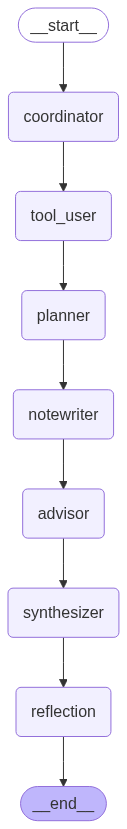

In [5]:
from IPython.display import Image, display

try:
    # Lấy ra đối tượng graph từ app đã biên dịch
    graph = app.get_graph()

    # Vẽ graph ra dưới dạng dữ liệu file PNG
    png_data = graph.draw_mermaid_png()

    # Hiển thị hình ảnh trực tiếp trong notebook
    display(Image(png_data))

except Exception as e:
    print(f"Lỗi khi vẽ graph: {e}")